# Silver

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [16]:
# ==========================================
# 1. Configuration (Updated for 'rtn'/'vol')
# ==========================================
class Config:
    # Data Settings
    FILE_PATH = '../preprocess/df_g2_processed.pkl'
    ASSET_NAME = 'XAG'  # Silver

    # Column Suffixes (CRITICAL FIX)
    # 前回の指示に合わせて rtn / vol に変更
    COL_RET_SUFFIX = '_rtn'
    COL_VOL_SUFFIX = '_vol'

    # Trend Filter (SMA)
    SMA_SHORT = 50
    SMA_LONG = 200

    # Price Breakout Filter
    PRICE_LOOKBACK = 20

    # Volatility Settings
    VOL_LOOKBACK = 100
    STD_ENTRY = 1.5          # 1st Breakpoint
    STD_EXIT_PROFIT = 2.5    # 2nd Breakpoint

    # Risk Management
    STOP_LOSS_PCT = 0.005    # 0.5% Hard Stop Loss
    COST_BPS = 0.0002        # Cost

In [17]:
# ==========================================
# 2. Data Preparation (Fixing KeyError)
# ==========================================
def prepare_data(file_path, cfg):
    try:
        df = pd.read_pickle(file_path)
        print(f"Data loaded from {file_path}")
    except FileNotFoundError:
        print("Error: File not found.")
        return None

    # Construct column names dynamically based on Config
    col_ret = f'{cfg.ASSET_NAME}{cfg.COL_RET_SUFFIX}'
    col_vol = f'{cfg.ASSET_NAME}{cfg.COL_VOL_SUFFIX}'

    # Check if columns exist before proceeding
    expected_cols = [cfg.ASSET_NAME, col_ret, col_vol]
    missing = [c for c in expected_cols if c not in df.columns]

    if missing:
        print(f"Error: Columns not found: {missing}")
        print(f"Available columns: {df.columns.tolist()}")
        return None

    # Extract relevant columns
    data = df[expected_cols].copy()
    data.columns = ['Close', 'Return', 'Vol'] # Standardize names internally

    # Drop NaNs
    data.dropna(inplace=True)

    # --- Indicator Calculation ---

    # 1. Trend (SMA)
    data['SMA_S'] = data['Close'].rolling(window=cfg.SMA_SHORT).mean()
    data['SMA_L'] = data['Close'].rolling(window=cfg.SMA_LONG).mean()

    # 2. Price Breakout (Donchian Channel High)
    data['Recent_High'] = data['Close'].rolling(window=cfg.PRICE_LOOKBACK).max().shift(1)

    # 3. Dynamic Volatility Bands
    vol_mean = data['Vol'].rolling(window=cfg.VOL_LOOKBACK).mean()
    vol_std = data['Vol'].rolling(window=cfg.VOL_LOOKBACK).std()

    data['Vol_Entry'] = vol_mean + (vol_std * cfg.STD_ENTRY)
    data['Vol_Climax'] = vol_mean + (vol_std * cfg.STD_EXIT_PROFIT)

    data.dropna(inplace=True)
    return data


In [18]:
# ==========================================
# 3. Strategy Simulation (Same as before)
# ==========================================
def run_strategy(df, cfg):
    data = df.copy()

    # Variables
    position = 0       # 0: Flat, 1: Long
    entry_price = 0.0
    stop_price = 0.0

    positions = []
    trade_logs = []

    # Convert to numpy for speed
    closes = data['Close'].values
    sma_s = data['SMA_S'].values
    sma_l = data['SMA_L'].values
    recent_highs = data['Recent_High'].values
    vols = data['Vol'].values
    vol_entry = data['Vol_Entry'].values
    vol_climax = data['Vol_Climax'].values
    dates = data.index

    print("Simulating trades...")

    for i in range(len(data)):
        current_price = closes[i]
        current_vol = vols[i]
        current_date = dates[i]

        # Conditions
        is_uptrend = sma_s[i] > sma_l[i]
        is_vol_breakout = current_vol > vol_entry[i]
        is_price_breakout = current_price > recent_highs[i]

        # --- Logic ---
        if position == 0:
            if is_uptrend and is_vol_breakout and is_price_breakout:
                position = 1
                entry_price = current_price
                stop_price = entry_price * (1 - cfg.STOP_LOSS_PCT)
                trade_logs.append({
                    'Type': 'Entry', 'Date': current_date, 'Price': current_price,
                    'Reason': f'Vol>{cfg.STD_ENTRY}std & Price Break'
                })

        elif position == 1:
            if current_price < stop_price:
                position = 0
                trade_logs.append({
                    'Type': 'Exit (SL)', 'Date': current_date, 'Price': current_price,
                    'Reason': 'Stop Loss Hit'
                })
            elif current_vol > vol_climax[i]:
                position = 0
                trade_logs.append({
                    'Type': 'Exit (Profit)', 'Date': current_date, 'Price': current_price,
                    'Reason': f'Vol>{cfg.STD_EXIT_PROFIT}std (Climax)'
                })
            elif current_vol < vol_entry[i]:
                position = 0
                trade_logs.append({
                    'Type': 'Exit (Normal)', 'Date': current_date, 'Price': current_price,
                    'Reason': f'Vol<{cfg.STD_ENTRY}std (Fade)'
                })

        positions.append(position)

    data['Position'] = positions
    return data, pd.DataFrame(trade_logs)

In [19]:
# ==========================================
# 4. Performance & Visualization (Same as before)
# ==========================================
def analyze_performance(data, trades, cfg):
    if trades.empty:
        print("No trades generated.")
        return

    data['Raw_Ret'] = data['Return'] * data['Position'].shift(1)

    trades_count = data['Position'].diff().abs().fillna(0)
    data['Cost'] = trades_count * cfg.COST_BPS

    data['Strategy_Ret'] = data['Raw_Ret'] - data['Cost']
    data['Equity'] = (1 + data['Strategy_Ret']).cumprod()

    total_ret = (data['Equity'].iloc[-1] - 1) * 100

    print("\n" + "="*40)
    print(f" PERFORMANCE SUMMARY: {cfg.ASSET_NAME}")
    print("="*40)
    print(f"Total Return:      {total_ret:.2f}%")
    print(f"Total Trades:      {len(trades)//2}")
    print("="*40)

    fig, axes = plt.subplots(3, 1, figsize=(18, 15), sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]})

    # Ax1: Equity
    axes[0].plot(data.index, data['Equity'], label='Strategy Equity (Net)', color='green', linewidth=2)
    axes[0].set_title('Cumulative Return (Net of Costs)', fontsize=14)
    axes[0].grid(True, alpha=0.3)

    # Ax2: Price & Entries
    axes[1].plot(data.index, data['Close'], label='Price', color='gray', alpha=0.5)
    entries = trades[trades['Type'] == 'Entry']
    exits_prof = trades[trades['Type'] == 'Exit (Profit)']
    exits_sl = trades[trades['Type'] == 'Exit (SL)']

    axes[1].scatter(entries['Date'], entries['Price'], marker='^', color='green', s=80, label='Entry', zorder=5)
    axes[1].scatter(exits_prof['Date'], exits_prof['Price'], marker='*', color='gold', s=120, edgecolors='black', label='Climax Exit', zorder=5)
    axes[1].scatter(exits_sl['Date'], exits_sl['Price'], marker='x', color='red', s=80, label='Stop Loss', zorder=5)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Ax3: Volatility
    axes[2].plot(data.index, data['Vol'], color='blue', linewidth=1, label='Volatility')
    axes[2].plot(data.index, data['Vol_Entry'], color='orange', linestyle='--', label=f'Entry (+{cfg.STD_ENTRY}std)')
    axes[2].plot(data.index, data['Vol_Climax'], color='red', linestyle='--', label=f'Climax (+{cfg.STD_EXIT_PROFIT}std)')
    axes[2].fill_between(data.index, 0, 1000, where=(data['Position']==1), color='green', alpha=0.1)
    axes[2].set_ylim(0, data['Vol_Climax'].max() * 1.5)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

Data loaded from ../preprocess/df_g2_processed.pkl
Simulating trades...

 PERFORMANCE SUMMARY: XAG
Total Return:      -16.42%
Total Trades:      622


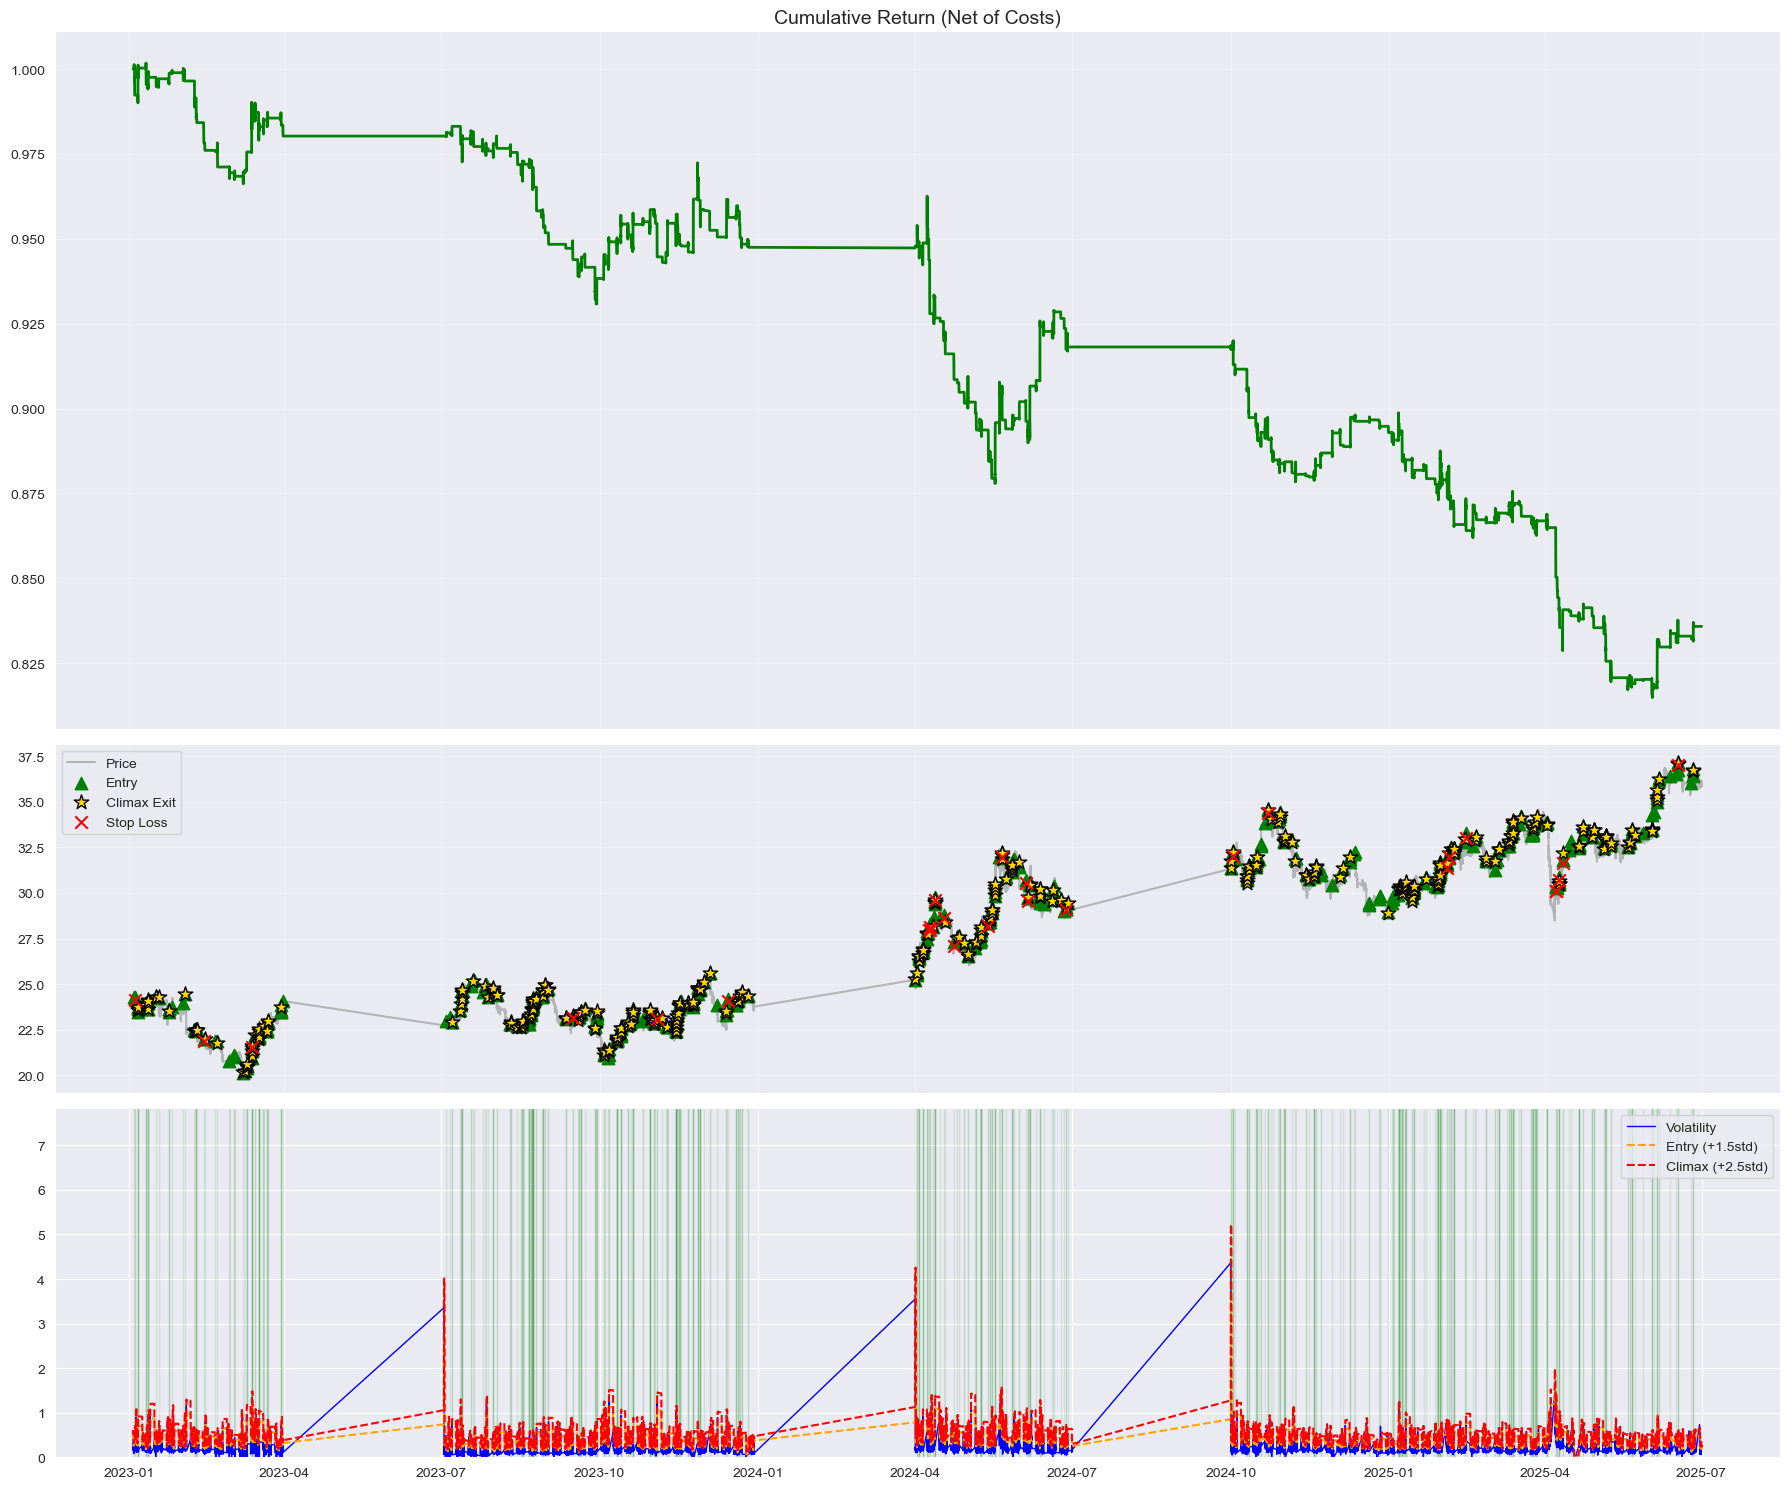


Recent Trades Log:


,Type,Date,Price,Reason
1234,Entry,2025-06-17 07:10:00,37.178,Vol>1.5std & Price Break
1235,Exit (SL),2025-06-17 08:00:00,36.992,Stop Loss Hit
1236,Entry,2025-06-25 02:45:00,36.036,Vol>1.5std & Price Break
1237,Exit (Normal),2025-06-25 03:00:00,36.017,Vol<1.5std (Fade)
1238,Entry,2025-06-26 04:00:00,36.390,Vol>1.5std & Price Break
1239,Exit (Normal),2025-06-26 04:20:00,36.389,Vol<1.5std (Fade)
1240,Entry,2025-06-26 04:50:00,36.456,Vol>1.5std & Price Break
1241,Exit (Profit),2025-06-26 04:55:00,36.698,Vol>2.5std (Climax)
1242,Entry,2025-06-26 05:00:00,36.779,Vol>1.5std & Price Break
1243,Exit (Profit),2025-06-26 05:05:00,36.742,Vol>2.5std (Climax)


In [20]:
# ==========================================
# 5. Main Execution
# ==========================================
cfg = Config()
df_processed = prepare_data(cfg.FILE_PATH, cfg)

if df_processed is not None:
    df_result, df_trades = run_strategy(df_processed, cfg)
    analyze_performance(df_result, df_trades, cfg)

    if not df_trades.empty:
        print("\nRecent Trades Log:")
        display(df_trades.tail(10))

Data loaded from ../preprocess/df_g2_processed.pkl

 PERFORMANCE BY QUARTER: XAG

[Quarterly Statistics]


,Quarter,Return,Trades,WinRate,MaxDD
0,2023_Q1,-1.97%,73,"4,657.53%",-3.55%
1,2023_Q3,-4.28%,93,"3,763.44%",-5.32%
2,2023_Q4,0.98%,106,"4,433.96%",-2.57%
3,2024_Q2,-3.10%,99,"4,343.43%",-8.79%
4,2024_Q4,-2.75%,70,"4,428.57%",-4.52%
5,2025_Q1,-2.91%,110,"3,909.09%",-4.09%
6,2025_Q2,-3.59%,71,"3,521.13%",-6.21%


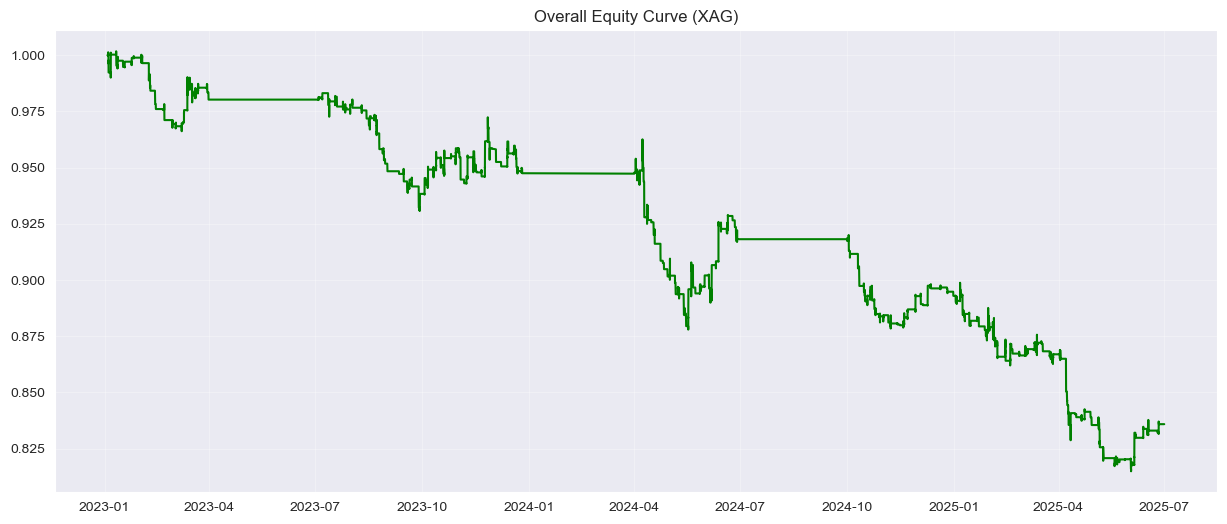

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. Configuration
# ==========================================
class Config:
    FILE_PATH = '../preprocess/df_g2_processed.pkl'
    ASSET_NAME = 'XAG'  # Silver

    # Column Suffixes
    COL_RET_SUFFIX = '_rtn'
    COL_VOL_SUFFIX = '_vol'

    # Parameters
    SMA_SHORT = 50
    SMA_LONG = 200
    PRICE_LOOKBACK = 20

    VOL_LOOKBACK = 100
    STD_ENTRY = 1.5
    STD_EXIT_PROFIT = 2.5

    STOP_LOSS_PCT = 0.005
    COST_BPS = 0.0002

# ==========================================
# 2. Data Preparation (Keep Quarter_ID)
# ==========================================
def prepare_data(file_path, cfg):
    try:
        df = pd.read_pickle(file_path)
        print(f"Data loaded from {file_path}")
    except FileNotFoundError:
        print("Error: File not found.")
        return None

    col_ret = f'{cfg.ASSET_NAME}{cfg.COL_RET_SUFFIX}'
    col_vol = f'{cfg.ASSET_NAME}{cfg.COL_VOL_SUFFIX}'

    # Check columns
    # Quarter_ID MUST be present
    expected_cols = [cfg.ASSET_NAME, col_ret, col_vol, 'Quarter_ID']
    missing = [c for c in expected_cols if c not in df.columns]

    if missing:
        print(f"Error: Columns not found: {missing}")
        return None

    # Extract
    data = df[expected_cols].copy()
    data.columns = ['Close', 'Return', 'Vol', 'Quarter_ID'] # Rename

    # Drop NaNs (Trend calc needs data, so drop carefully)
    data.dropna(subset=['Close', 'Return', 'Vol'], inplace=True)

    # Indicators
    data['SMA_S'] = data['Close'].rolling(window=cfg.SMA_SHORT).mean()
    data['SMA_L'] = data['Close'].rolling(window=cfg.SMA_LONG).mean()
    data['Recent_High'] = data['Close'].rolling(window=cfg.PRICE_LOOKBACK).max().shift(1)

    vol_mean = data['Vol'].rolling(window=cfg.VOL_LOOKBACK).mean()
    vol_std = data['Vol'].rolling(window=cfg.VOL_LOOKBACK).std()

    data['Vol_Entry'] = vol_mean + (vol_std * cfg.STD_ENTRY)
    data['Vol_Climax'] = vol_mean + (vol_std * cfg.STD_EXIT_PROFIT)

    data.dropna(inplace=True)
    return data

# ==========================================
# 3. Strategy Logic (Same)
# ==========================================
def run_strategy(df, cfg):
    data = df.copy()

    position = 0
    entry_price = 0.0
    stop_price = 0.0

    positions = []
    trade_logs = []

    # Numpy conversion
    closes = data['Close'].values
    sma_s = data['SMA_S'].values
    sma_l = data['SMA_L'].values
    recent_highs = data['Recent_High'].values
    vols = data['Vol'].values
    vol_entry = data['Vol_Entry'].values
    vol_climax = data['Vol_Climax'].values
    dates = data.index
    q_ids = data['Quarter_ID'].values # Keep track of Quarter

    for i in range(len(data)):
        current_price = closes[i]
        current_vol = vols[i]
        current_date = dates[i]
        current_q = q_ids[i]

        is_uptrend = sma_s[i] > sma_l[i]
        is_vol_breakout = current_vol > vol_entry[i]
        is_price_breakout = current_price > recent_highs[i]

        if position == 0:
            if is_uptrend and is_vol_breakout and is_price_breakout:
                position = 1
                entry_price = current_price
                stop_price = entry_price * (1 - cfg.STOP_LOSS_PCT)
                trade_logs.append({
                    'Quarter_ID': current_q, # Add Quarter info
                    'Type': 'Entry', 'Date': current_date, 'Price': current_price,
                    'Reason': 'Entry'
                })

        elif position == 1:
            exit_type = None
            if current_price < stop_price:
                exit_type = 'Exit (SL)'
            elif current_vol > vol_climax[i]:
                exit_type = 'Exit (Profit)'
            elif current_vol < vol_entry[i]:
                exit_type = 'Exit (Normal)'

            if exit_type:
                position = 0
                # Calculate Trade PnL (approx)
                pnl = (current_price - entry_price) - (current_price + entry_price)*cfg.COST_BPS
                trade_logs.append({
                    'Quarter_ID': current_q,
                    'Type': exit_type, 'Date': current_date, 'Price': current_price,
                    'PnL': pnl,
                    'Reason': exit_type
                })

        positions.append(position)

    data['Position'] = positions
    return data, pd.DataFrame(trade_logs)

# ==========================================
# 4. Performance by Quarter (New!)
# ==========================================
def analyze_performance_by_quarter(data, trades, cfg):
    # Calculate Strategy Returns first
    data['Raw_Ret'] = data['Return'] * data['Position'].shift(1)
    trades_count = data['Position'].diff().abs().fillna(0)
    data['Cost'] = trades_count * cfg.COST_BPS
    data['Strategy_Ret'] = data['Raw_Ret'] - data['Cost']

    # --- Group by Quarter_ID ---
    quarters = data['Quarter_ID'].unique()
    quarters = np.sort(quarters) # Sort chronologically if possible

    stats_list = []

    print(f"\n{'='*60}")
    print(f" PERFORMANCE BY QUARTER: {cfg.ASSET_NAME}")
    print(f"{'='*60}")

    for q in quarters:
        # Filter data for this Quarter
        df_q = data[data['Quarter_ID'] == q].copy()

        if df_q.empty:
            continue

        # 1. Cumulative Return for this Quarter
        # (1 + r1) * (1 + r2) ... - 1
        cum_ret = (1 + df_q['Strategy_Ret']).cumprod().iloc[-1] - 1

        # 2. Number of Trades (Entries in this Quarter)
        # Using trade logs is more accurate for counting
        if not trades.empty:
            trades_q = trades[(trades['Quarter_ID'] == q) & (trades['Type'] == 'Entry')]
            num_trades = len(trades_q)

            # Win Rate (based on exits in this quarter)
            exits_q = trades[(trades['Quarter_ID'] == q) & (trades['Type'].str.contains('Exit'))]
            if not exits_q.empty:
                # Need to match exits to PnL. The PnL is recorded in the Exit row in run_strategy
                # Note: This is simplified. PnL is calculated in run_strategy for reporting
                # But 'PnL' column only exists in trade_logs rows where Type is Exit.
                wins = len(exits_q[exits_q['PnL'] > 0])
                win_rate = (wins / len(exits_q)) * 100
            else:
                win_rate = 0.0
        else:
            num_trades = 0
            win_rate = 0.0

        # 3. Max Drawdown in this Quarter
        equity_q = (1 + df_q['Strategy_Ret']).cumprod()
        peak = equity_q.cummax()
        dd = (equity_q - peak) / peak
        max_dd = dd.min()

        stats_list.append({
            'Quarter': q,
            'Return': cum_ret,
            'Trades': num_trades,
            'WinRate': win_rate,
            'MaxDD': max_dd
        })

    # Create DataFrame for display
    stats_df = pd.DataFrame(stats_list)

    # Formatting
    pd.options.display.float_format = '{:,.2%}'.format
    # Trades is integer, handle format manually if needed, or just let it be float in view

    # Display the stats table
    # Only format percentage columns
    display_df = stats_df.copy()
    display_df['Trades'] = display_df['Trades'].astype(int)

    print("\n[Quarterly Statistics]")
    display(display_df)

    # Plotting Equity Curve separated by Quarter to avoid straight lines
    # We will plot them side-by-side or just one by one to show gaps
    plt.figure(figsize=(15, 6))

    # Global cumulative for the plot
    # To handle gaps properly in a single plot, we can just plot the points/lines
    # But usually, simply plotting the whole series with gaps in index works if index is Datetime
    # If there are large time gaps, matplotlib connects them.
    # We will simply plot the Strategy Equity.

    # Since we want to visualize per Quarter, let's just plot the continuous equity
    # but acknowledge the stats table is the main decision tool.

    equity = (1 + data['Strategy_Ret']).cumprod()
    plt.plot(data.index, equity, label='Total Equity', color='green')
    plt.title(f'Overall Equity Curve ({cfg.ASSET_NAME})')
    plt.grid(True, alpha=0.3)
    plt.show()

# ==========================================
# 5. Execution
# ==========================================
cfg = Config()
df_processed = prepare_data(cfg.FILE_PATH, cfg)

if df_processed is not None:
    df_result, df_trades = run_strategy(df_processed, cfg)
    analyze_performance_by_quarter(df_result, df_trades, cfg)